<!--
IRdisplay::display_html(file='code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>


**Author**: Adrian Ernesto Radillo  
**Date**: 22 Feb 2019
### LINKS TO MAIN SECTIONS
[Introduction](#intro)  
[Data pre-processing](#preproc)  
[Timing and trials checks](#checks)  
[Accuracy analysis](#acc)  
[Dot count in hemifields](#dotcount)  
[Autocorrelation of choices](#autocorr)  
[Reverse correlation analysis](#revker)

# Introduction
<a id='intro'></a>
## Notebook's goals

Analyze data collected on myself. Two subgoals:
1. make sure the task and stimulus behave as we want, to the smallest detail
2. start building up an analysis pipeline for the actual study

### Immediate results
1. First trial shows _weird_ timing, and first five to ten trials in general have an abnormally long delay between `trialStart` and `fixationOn`. So, based on some tolerance level, we should discard the first few trials.
2. This document is a series of basic questions that I ask about the data, and that I try to answer (with graphs when I can)

## A word on the data for this notebook
The tag for this data is `Pilot 11`. It was collected in the psychophysics booth with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot11.mat).

I timed with my phone the elapsed time between launching the task via the GUI and the time of closing the GUI.
This roughly amounted to 31 minutes.

## Feedback about my own impressions doing the task
- Luminance on booth's screen is too high (almost hurts my eyes)
- As dots coherence changes, so does the effective speed of the dots. I perceived much faster moving/fluctuating dots at low coherence levels than at high ones. This might be a problem...
- I usually need a few minutes of break every 5 to 10 minutes. I guess it will be the same for the subjects.
- sometimes, and involuntary head or eye movement during stimulus presentation changes the perception of the dots (they become lines). I don't know if the eye-tracker will pick up on that, but if it doesn't it is an issue.
- Getting comfy in front of the screen is ultra important, and not so easy to achieve
- Thus, doing several trials (at least 40) in presence of the experimenter to give him oral, real-time feedback, is really important.


## Data analysis workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (appropriate branch must be chosen).
  1. A `.mat` data file is outputted
  2. I usually manually rename this file `pilot#.mat` and upload it to PennBox (location = Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/02109ab98b956f2aad4ac15f01e1d373260c8af0/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- There is a clear problem in the way my code defines change points. This needs to be fixed.
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- With 345 trials, dotsPositions.csv file is already around 80 MB big with more than a million rows! This is too much.
    - I could remove a lot of the 'dumping'
    - I could try to adopt the [NWB](https://www.nwb.org/) data format.

## Unordered Q&A
**Q:** How many frames are skipped on each trial, and where in the trial do they occur?  
**A:** No frames are skipped (see figure in [this section](#tightFrames))  

**Q:** Plot indep var. as fcn of trial count, to ensure real randomization was implemented by the task algorithm.  
**A:** Things look fine [here](#randIndVar).
    
**Q:** Why [this pattern of errors](#errorsVD) in `(dotsOff-dotsOn) - viewingDuration`?  
**A: Unanswered**  


**Q:** Why [these dots counts](#numDots)?  
**A: Unanswered**  

**Q:** Do subjects display a tendency to repeat the answer from the last trial?  
**A:** Can [autocorrelation](#autocorr) tell us something?  


**Q:** Do subjects use the dot count in each half of the screen to make up their mind at low coherence levels?  
**A:** It doesn't seem so according to [this section](#dotcount).


**Q:** Compute reverse kernels with the (signed) number of coherent dots as a proxy for motion energy  
**A: Unanswered**

In [1]:
# load packages 

# Note:
# if one of the packages below is not installed, type, once, in another cell
# install.packages("<package_name>", lib="<path_to_installation_folder>")
# ref:https://www.rdocumentation.org/packages/utils/versions/3.5.2/topics/install.packages

library(data.table)     # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)        # for plots
library(repr)           # for resizing figures
library(OneR)           # to use the function 'bin'
library(gridExtra)      # to use grid.arrange()
source("R_functions.r") # custom functions


In [2]:
# DEFINE CONSTANTS
# folder/file-specific constants
PILOT_NUMBER <- 11
DATA_FOLDER <- "../data/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# data-related constants
FIRST_TRIALS_TO_DISCARD <- 1

# plot-specific constants
PLOT_TITLE_FONT_SIZE <- 18
PLOT_SUBTITLE_FONT_SIZE <- 13 
AXES_LABEL_FONT <- 14
AXES_FONT <- 13

ERROR_WIDTH <- 4
SMALL_ERROR_WIDTH <- .01*ERROR_WIDTH

LINE_WIDTH <- 1.4
POINT_SIZE <- 2
SMALL_DOT_SIZE <- 1

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [3]:
# load csv files into data.tables
TRIALS <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG)
FRAMES <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG)
DOTS <- loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG)

# Data pre-processing
<a id='preproc'></a>
## Summary of `TRIALS` dataset (`*FIRA.csv` file)

In [4]:
# set some variables to "factor"
TRIALS[,`:=`(choice=as.factor(choice), 
            correct=as.logical(correct), # probably a bad idea to have this be a factor variable
            initDirection=as.factor(initDirection),
            endDirection=as.factor(endDirection),
            presenceCP=as.logical(presenceCP))]
# put back in missing values
TRIALS[choice == 'NaN' | correct == 'NaN', `:=`(choice = NA, correct = NA)] 

# display summary for reference
str(TRIALS)

Classes ‘data.table’ and 'data.frame':	504 obs. of  27 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  887 300 281 564 112 279 892 879 351 184 ...
 $ trialStart     : num  1211394 1211400 1211405 1211409 1211414 ...
 $ trialEnd       : num  1211400 1211405 1211409 1211414 1211418 ...
 $ RT             : num  1.275 0.921 0.86 1.125 0.875 ...
 $ choice         : Factor w/ 3 levels "0","1","NaN": 2 1 1 1 1 1 1 2 2 2 ...
 $ correct        : logi  TRUE TRUE TRUE TRUE FALSE TRUE ...
 $ initDirection  : Factor w/ 2 levels "0","180": 1 2 1 2 2 1 2 1 1 2 ...
 $ endDirection   : Factor w/ 2 levels "0","180": 1 2 2 2 1 2 1 1 1 2 ...
 $ presenceCP     : logi  FALSE FALSE TRUE FALSE TRUE TRUE ...
 $ coherence      : int  60 60 24 60 12 12 12 12 12 12 ...
 $ viewingDuration: num  0.4 0.5 0.4 0.2 0.5 0.4 0.5 0.4 0.5 0.1 ...
 $ probCP         : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ r

## Summary of `FRAMES` dataset (`*framesInfo.csv` file)

In [5]:
str(FRAMES)

Classes ‘data.table’ and 'data.frame':	11353 obs. of  6 variables:
 $ frameTotCount: int  3 4 5 6 7 8 9 10 11 12 ...
 $ onsetTime    : num  1211394 1211397 1211397 1211397 1211397 ...
 $ onsetFrame   : int  205 392 400 403 404 405 406 407 408 409 ...
 $ swapTime     : num  1211394 1211397 1211397 1211397 1211397 ...
 $ isTight      : int  0 0 0 0 1 1 1 1 1 1 ...
 $ trialIndex   : int  887 887 887 887 887 887 887 887 887 887 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Summary of `DOTS` dataset (`*dotsPositions.csv` file)

In [6]:
str(DOTS)

Classes ‘data.table’ and 'data.frame':	1713348 obs. of  6 variables:
 $ xpos      : num  0.201 0.322 0.205 0.548 0.362 ...
 $ ypos      : num  0.465 0.293 0.105 0.341 0.515 ...
 $ isActive  : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent: int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount: int  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


<a id='numDots'>TODO: investigate why two numbers instead of one below.</a>

In [7]:
cat("number of active dots per frame appearing across trials",
    unique(DOTS[,.(numDots=sum(isActive)), by=.(trialCount,frameIdx)][,numDots])
    ,"\n")

number of active dots per frame appearing across trials 61 60 


## Classify trials
We classify trials as follows:
- `valid` means that the trial is kept in the analysis
- `skipped` means that no answer was recorded (this could be linked to fixation break for instance)
- `bug` means the code itself renders the trial unusable (for instance the 1st trial, because of our timing bug)
- `early` means that an answer was provided before the end of the viewing duration

Currently, I don't control for the fact that a single trial might fall into more than one non-valid category. I just make sure all `valid` trials are indeed valid.

In [8]:
TRIALS[order(trialStart),`:=`(trialClass='valid', trialInSession=.I)]
TRIALS[is.na(choice), trialClass:='skipped']
TRIALS[trialInSession <= FIRST_TRIALS_TO_DISCARD, trialClass:='bug']
TRIALS[RT <= 0, trialClass:='early']
TRIALS[,trialClass:=as.factor(trialClass)]

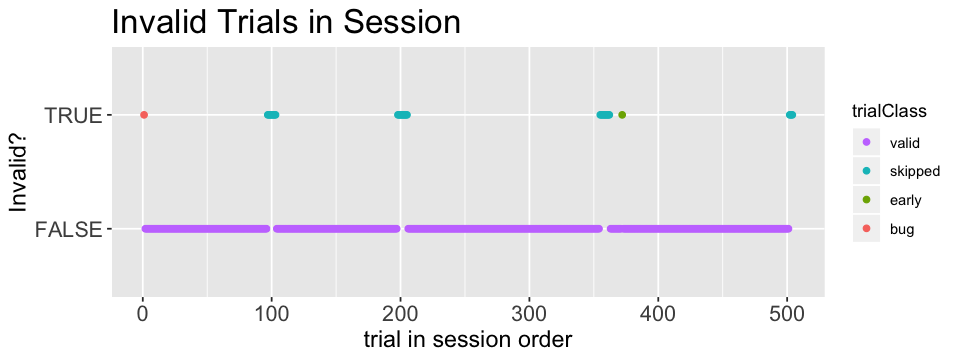

In [9]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=3)

ggplot(TRIALS, aes(x=trialInSession, y=trialClass != 'valid')) + 
    geom_point(aes(col=trialClass)) +
    labs(title="Invalid Trials in Session", x="trial in session order", y="Invalid?") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15,family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT)) + # Y axis text
    guides(colour = guide_legend(reverse=T))

## Match trials across datasets

How many trials were produced in each dataset?

In [10]:
cat('TRIALS',nrow(TRIALS),
   '\nDOTS  ',DOTS[,max(trialCount)],
   '\nFRAMES',nrow(FRAMES[,.N,by=trialIndex])) # can I improve this syntax? 
# nrow is inefficient compared to .N
#the following URL are enlightening
#https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html

TRIALS 504 
DOTS   478 
FRAMES 496

We need to get the trials to match across datasets. 

Let's introduce a `validTrialCount` column in all datasets, with invalid trials flagged `validTrialCount=NA_integer_`.

In [11]:
TRIALS[trialClass == 'valid', validTrialCount:=.I]
TRIALS[trialClass != 'valid', validTrialCount := NA_integer_]

In [12]:
# cat('TRIALS data.table has',
#     nrow(TRIALS[!is.na(validTrialCount),.(validTrialCount)]),
#     'valid trials with min, max values') 
# TRIALS[!is.na(validTrialCount),.(min(validTrialCount),max(validTrialCount))]
cat('TRIALS dataset has a total of',TRIALS[,sum(trialClass=='valid')],'valid trials')

TRIALS dataset has a total of 476 valid trials

In [13]:
# to match TRIALS to FRAMES, we use timestamps. 

# add the validTrialCount col to FRAMES, with 0 entries for now
FRAMES[,validTrialCount:=0]
# str(FRAMES)

# NOTE: following for loop is SLOW, but I don't know of a way to speed things up
# TODO: post question online

# loop through rows in FRAMES and set trialCount appropriately
for (numRow in 1:nrow(FRAMES)) {
    frameOnset <- FRAMES[numRow, onsetTime]
    if (length(TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,validTrialCount]) == 0) {
        cat('discarding frame from row ',numRow, 'in FRAMES\n')
        FRAMES[numRow, "validTrialCount"] <- NA_integer_
    } else if (length(TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,validTrialCount]) > 1) {
        cat('row ',numRow, 'in FRAMES falls in more than one trial!\n')
    } else {
        FRAMES[numRow, "validTrialCount"] <- TRIALS[trialStart <= frameOnset & trialEnd >= frameOnset,validTrialCount]
    }
}

cat('FRAMES dataset, after filtering, has a total of',
nrow(FRAMES[!is.na(validTrialCount),.N,by=validTrialCount]), 'valid trials')

discarding frame from row  11353 in FRAMES
FRAMES dataset, after filtering, has a total of 476 valid trials

In [14]:
# ggplot(FRAMES[!is.na(validTrialCount),.(numFrames=.N),by=validTrialCount], aes(x=validTrialCount, y=numFrames)) + geom_line()
# ggplot(TRIALS[!is.na(validTrialCount),.(VD=dotsOff-dotsOn),by=validTrialCount], aes(x=validTrialCount, y=VD)) + geom_line()

Hurray, we managed to match `FRAMES` and `TRIALS`! Let's deal with the `DOTS` dataset now.

In [15]:
tmp_dt <- TRIALS[!is.na(choice)]
tmp_dt[,trialCount := .I] # the trialCount col is meant to match the trialCount col from DOTS dataset

# uncomment below to perform the checks
# tmp_dt[,.(min(trialCount),max(trialCount))]
# nrow(tmp_dt[,.(trialCount)])
# DOTS[,.(min(trialCount),max(trialCount))]
# nrow(DOTS[,.(.N),by=trialCount])

In [16]:
# let's perform an inner join now
setkey(DOTS, trialCount)
setkey(tmp_dt, trialCount)
DOTS <- DOTS[tmp_dt, nomatch=0]
# str(DOTS)

In [17]:
# And we are done!
# cat('new DOTS data.table has',
#     nrow(DOTS[!is.na(validTrialCount),.N,by=validTrialCount]),
#     'valid trials with min, max values') 
# DOTS[!is.na(validTrialCount),.(min=min(validTrialCount), max=max(validTrialCount))]

Now the three datasets should perfectly match via the column `validTrialCount`!

In [18]:
cat('Dataset trials',
    '\nTRIALS  ',nrow(TRIALS[!is.na(validTrialCount)]),
    '\nDOTS    ',nrow(DOTS[!is.na(validTrialCount),.N,by=validTrialCount]),
    '\nFRAMES  ',nrow(FRAMES[!is.na(validTrialCount),.N,by=validTrialCount]),
    "\n\nIf all of the above match, it's a good sign!")

Dataset trials 
TRIALS   476 
DOTS     476 
FRAMES   476 

If all of the above match, it's a good sign!

# Timing and trial checks
<a id='checks'></a>
How long did the session last?

In [19]:
cat( round(TRIALS[,sum(trialEnd - trialStart)] / 60, digits = 2), "min" )

31.36 min

<!-- this is not so important anymore.
Were some trials presented again after failure? -->

In [20]:
# print("below are the trial counts corresponding to trials that were presented a second time (lapse)")
# TRIALS[,.(trialIndex, trialCount)][duplicated(TRIALS[,.(trialIndex)])]

- How many trials were produced per combination of factors? **(TODO: any better way of displaying these results?)**

In [21]:
print("visualization pending")
#indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
# combFactors <- getFreq(TRIALS, indepVarNames)
# combFactors

[1] "visualization pending"


- What were the marginal frequencies? **(TODO:improve visualization)**

In [22]:
print("visualization pending")
# for (i in 1:length(indepVarNames)) {
#   print(getFreq(TRIALS, indepVarNames[i]))
# }

[1] "visualization pending"


## Random indep vars.
<a id='randIndVar'></a>
We now plot the independent variables as a function of trial number in the task, to check randomization (at least eye-balling).

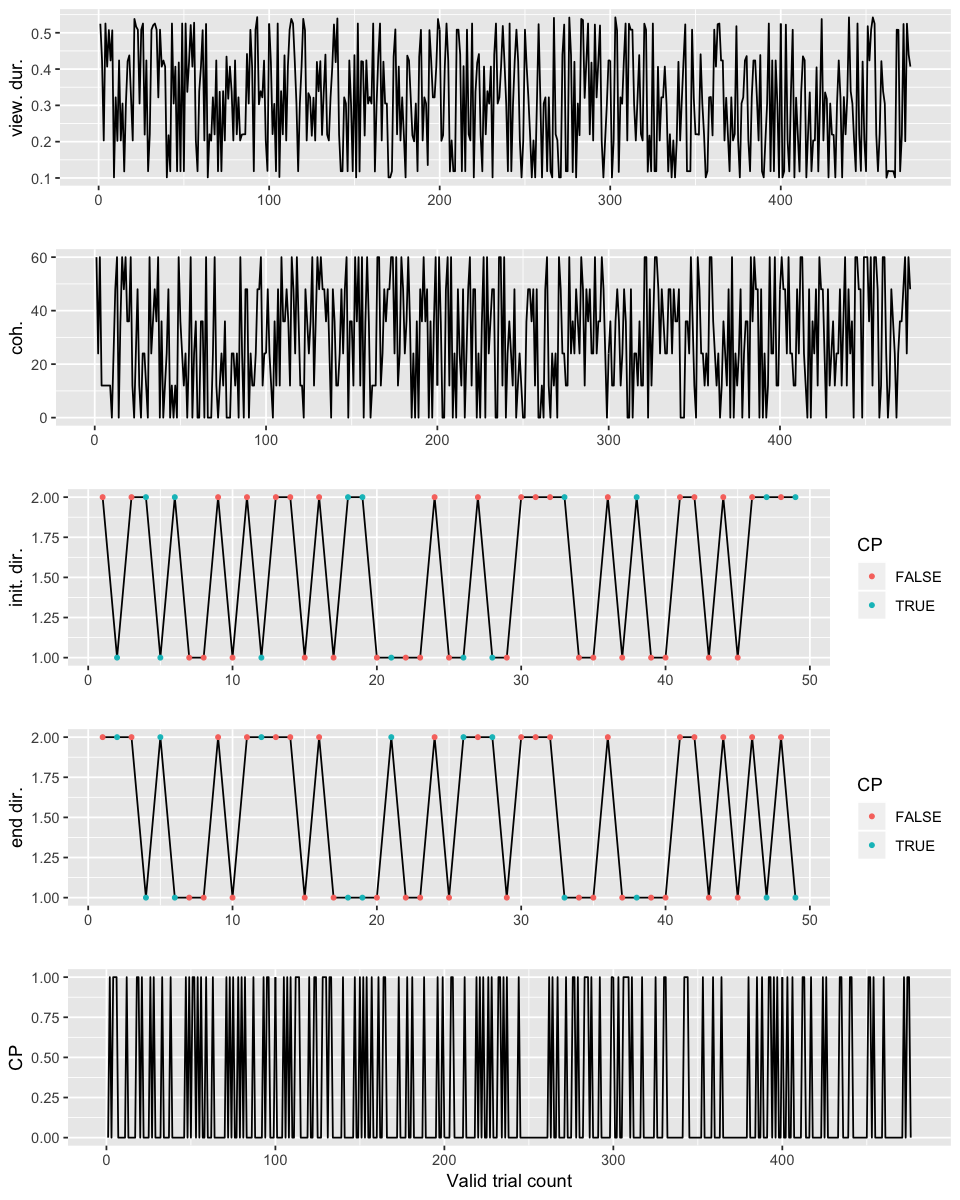

In [23]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=10)


p1 <- ggplot(TRIALS[!is.na(validTrialCount)], aes(x=validTrialCount, y=dotsOff - dotsOn)) + 
    geom_line() +
    labs(x="", y="view. dur.")


p2 <- ggplot(TRIALS[!is.na(validTrialCount)], aes(x=validTrialCount, y=coherence)) +
    geom_line() +
    labs(x="", y="coh.")


p3 <- ggplot(TRIALS[!is.na(validTrialCount) & validTrialCount < 50], 
             aes(x=validTrialCount, y=as.numeric(initDirection))) + 
    geom_line() + geom_point(aes(col=presenceCP), size=SMALL_DOT_SIZE) +
    labs(x="", y="init. dir.", colour="CP")


p4 <- ggplot(TRIALS[!is.na(validTrialCount) & validTrialCount < 50], 
             aes(x=validTrialCount, y=as.numeric(endDirection))) + 
    geom_line() + geom_point(aes(col=presenceCP), size=SMALL_DOT_SIZE) +
    labs(x="", y="end dir.", colour="CP")


p5 <- ggplot(TRIALS[!is.na(validTrialCount)], aes(x=validTrialCount, y=as.numeric(presenceCP))) + 
    geom_line() + 
    labs(x="Valid trial count", y="CP")

grid.arrange(p1,p2,p3,p4,p5, nrow=5) 

## Match frame count across datasets
<a id='frame_times'></a>

In [24]:
# we work on a custom data.table containing the frames data and a few columns from the TRIALS table

# first we discard aborted trials
frameTimes <- FRAMES[!is.na(validTrialCount),]

# then we add some columns from TRIALS (the syntax is that of a right join)
frameTimes <- FRAMES[TRIALS[!is.na(validTrialCount),
                            .(trialStart, trialEnd,
                              dotsOn, dotsOff, 
                              validTrialCount, 
                              numFrames)], on="validTrialCount"]

# only consider frames with onsetTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[onsetTime-trialStart>=dotsOn & onsetTime-trialStart <= dotsOff]

In [25]:
# we now create a custom data.table to hold the frame count from the three files.
tmp_frames <- frameTimes[,.(FRAMESframeCount=.N), by=validTrialCount]
tmp_trials <- unique(frameTimes[,.(TRIALSframeCount=numFrames), by=validTrialCount])
tmp_dots <- DOTS[!is.na(validTrialCount),.(DOTSframeCount=max(frameIdx)),by=validTrialCount]

# head(frameTimes)
# head(tmp_frames)
# head(tmp_trials)
# head(tmp_dots)

# merge the three data.tables above in a single call (inspiration from here https://stackoverflow.com/a/13274291)
frameCounts <- Reduce(merge, list(tmp_frames,tmp_trials,tmp_dots))
# head(frameCounts)

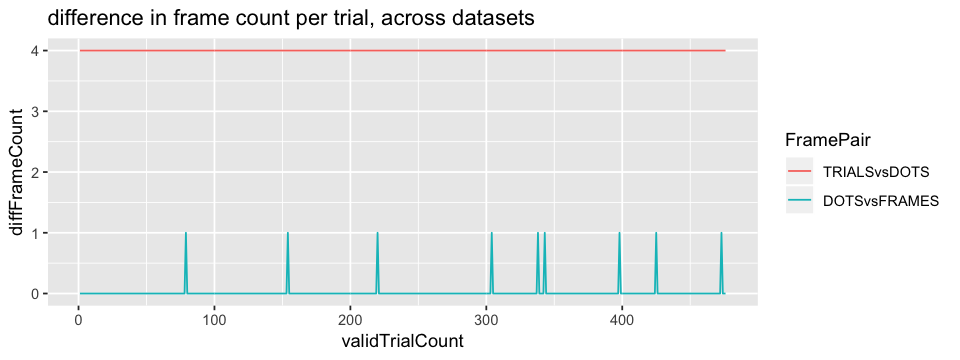

In [26]:
# add 2 cols for difference in frame count (see section 2a here: https://cran.r-project.org/web/packages/data.table/vignettes/datatable-reference-semantics.html)
diffNumFrames <- melt(frameCounts[,`:=`(TRIALSvsDOTS = TRIALSframeCount - DOTSframeCount,
                                        DOTSvsFRAMES = DOTSframeCount - FRAMESframeCount)],
                      id.vars=c("validTrialCount"),
                      measure.vars=c("TRIALSvsDOTS","DOTSvsFRAMES"),
                      value.name="diffFrameCount", variable.name="FramePair")

# control output figure size
options(repr.plot.width=8, repr.plot.height=3)

# head(diffNumFrames)
ggplot(diffNumFrames, aes(x=validTrialCount, y=diffFrameCount)) + geom_line(aes(col=FramePair)) +
    ggtitle("difference in frame count per trial, across datasets")

From the columns above, we see that:
- the `numFrames` field from the `TRIALS` table is not useful
- counting the frames from the `FRAMES` dataset, filtering by timestamps, _runs the risk of being off by 1 frame_.
- so for motion energy, I'll stick to the `DOTS` dataset for now.

## A deeper look at the timestamps fields

In [27]:
wideTimestamps <- TRIALS[!is.na(validTrialCount),.(trialStart=trialStart-trialStart,
                                  trialEnd=trialEnd-trialStart,
                                  dotsOn,
                                  dotsOff,
                                  tocDotsOn,
                                  tocDotsOff,
                                  nDotsOn=dotsOn - tocDotsOn,
                                  nDotsOff=dotsOff - tocDotsOn,
                                  nTocDotsOn=tocDotsOn - tocDotsOn,
                                  nTocDotsOff=tocDotsOff - tocDotsOn,
                                  targetOn,
                                  fixationOn,
                                  choiceTime,
                                  presenceCP),by=validTrialCount]

In [28]:
# refTime <- wideTimestamps[,.(trialCount,
#     trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
#                         by=trialIndex]
longTimestamps <- melt(wideTimestamps,
                       id.vars=c("validTrialCount"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
# str(longTimestamps)

Recall that in the plot below, `targetOn` corresponds to the display time of the targets, which requires first the subject to *hold fixation*.

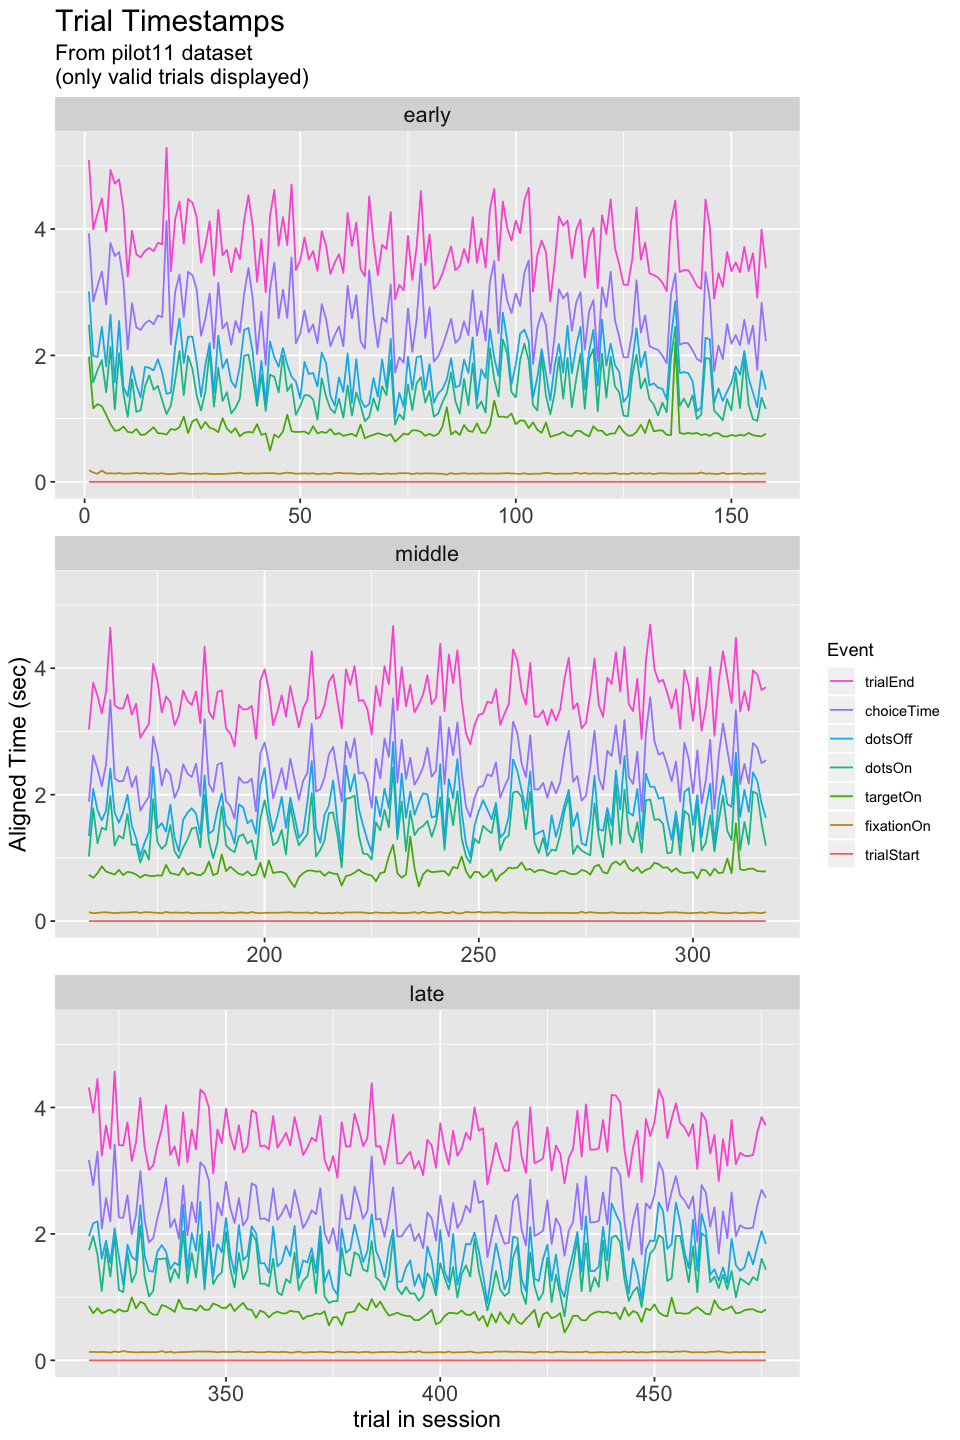

In [29]:
# since we have many trials, let's split the plots in 3
longTimestamps[, sessionPeriod:='early']
longTimestamps[validTrialCount > max(validTrialCount) / 3, sessionPeriod:='middle']
longTimestamps[validTrialCount > 2 * max(validTrialCount) / 3, sessionPeriod:='late']
longTimestamps[, sessionPeriod := factor(sessionPeriod, levels=c("early", "middle", "late"))]
# control output figure size
options(repr.plot.width=8, repr.plot.height=12)

# plot
ggplot(longTimestamps, aes(x=validTrialCount, y=timestamp)) + #geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.5) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    facet_wrap(~sessionPeriod, nrow=3, scales="free_x") + 
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset\n(only valid trials displayed)",sep=""),
         y="Aligned Time (sec)", x="trial in session") + 
    theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
            plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
            plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT),
             strip.text=element_text(size=PLOT_SUBTITLE_FONT_SIZE))  # Y axis text

### Dots timing
<a id='errorsVD'></a>
We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

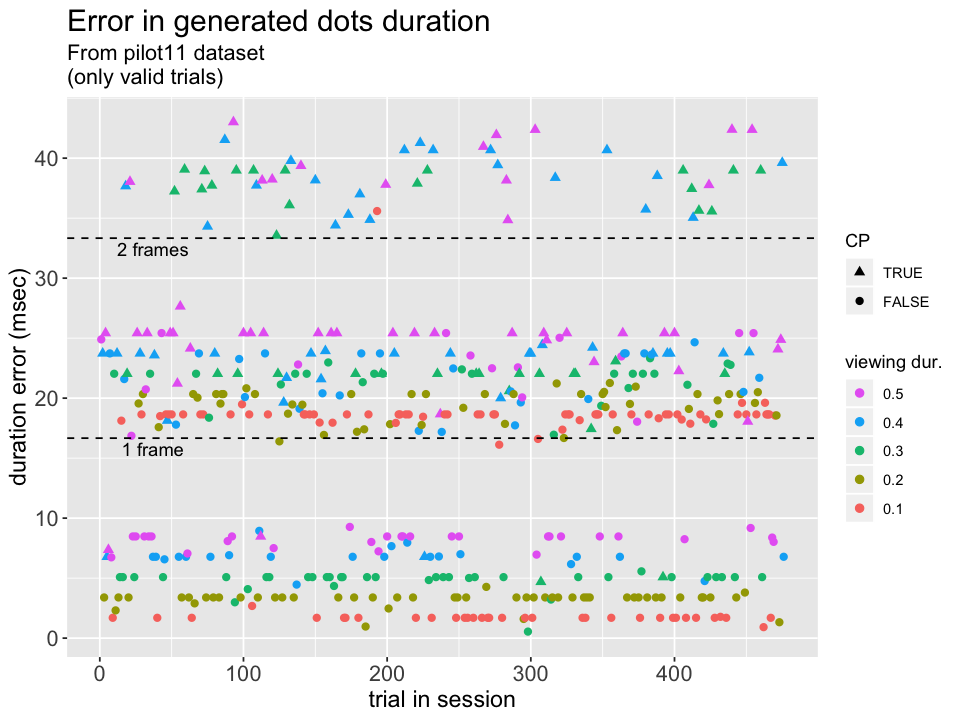

In [30]:
durTable <- TRIALS[!is.na(validTrialCount),.(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, 
                            presenceCP, 
                            viewingDuration), 
                        by=validTrialCount]

horizLines <- c(FRAME_DURATION*1000,FRAME_DURATION * 2000)

# control output figure size
options(repr.plot.width=8, repr.plot.height=6)


# call to ggplot()
g <- ggplot(durTable, aes(x=validTrialCount, y=dotsDurationError)) + 
#   geom_line(size=.2) +  
  geom_point(aes(shape=presenceCP, col=factor(viewingDuration)),size=POINT_SIZE) +
  geom_hline(yintercept = horizLines, linetype="dashed") +
  annotate("text", x=37, y=horizLines, vjust = 1.3, label = c("1 frame","2 frames"))
# Add Title and Labels
g + labs(title="Error in generated dots duration", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset\n(only valid trials)",sep=""), 
         y="duration error (msec)", 
         x="trial in session",
         colour="viewing dur.", shape="CP") + 
    guides(colour = guide_legend(reverse=T), shape=guide_legend(reverse=T)) +
    theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
            plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
            plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

The plot above shows that most real viewing durations are roughly 20 msec longer than the intended ones.
In a sizeable number of trials, the error rises to 40 msec, and this almost exclusively happens on change point trials.

Below I try to estimate the mean errors, clustered. 

In [31]:
print("empty for now")
# intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
# names(intervals) <- "interval"

# # add the bins as a factor to the data.table
# durTable[, ("interval") := intervals]

# # compute mean durations
# unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# # display results, with num_frame column
# unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * FRAME_RATE_ESTIMATE / 1000))]

[1] "empty for now"


### Tic/toc dots durations
Below I specifically compare the `dotsOn` and `dotsOff` values that I got from the task and from the `tic/toc` 
calls.

In [32]:
# visualization in this cell not very interesting/readable
# I switched to the boxplots below
# longDotsOffTimestamps <- melt(wideTimestamps,
#                        id.vars=c("validTrialCount","presenceCP"),
#                        measure.vars=c("nTocDotsOn","nDotsOn","nTocDotsOff","nDotsOff"),
#                        value.name="timestamp", variable.name="Event")

# # control output figure size
# options(repr.plot.width=8, repr.plot.height=8)

# # plot
# ggplot(longDotsOffTimestamps, aes(x=validTrialCount, y=timestamp)) + 
#    geom_point(aes(col=Event, shape=presenceCP), size=POINT_SIZE) +
# #    geom_line(aes(col=Event),size=.2) +
# #    geom_hline(yintercept = frameDurations, linetype="dashed") +
#     guides(colour = guide_legend(reverse=T)) +
#     labs(title="Trial Timestamps",
#          subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
#         shape="Change Point") + theme(plot.title=element_text(size=20,
#                                     lineheight=1.2),  # title
#             plot.subtitle=element_text(size=15),  # subtitle
#             plot.caption=element_text(size=15),  # caption
#             axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
#             axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
#             axis.text.x=element_text(size=AXES_FONT),  # X axis text
#             axis.text.y=element_text(size=AXES_FONT))  # Y axis text



In [33]:
#inspecting levels
# levels(melt(ticTocOffsets,
#             id.vars=c("validTrialCount"),
#             measure.vars=c("dotsOnOffset","dotsOffOffset"),
#             value.name="timestamp", variable.name="Event")[,Event])

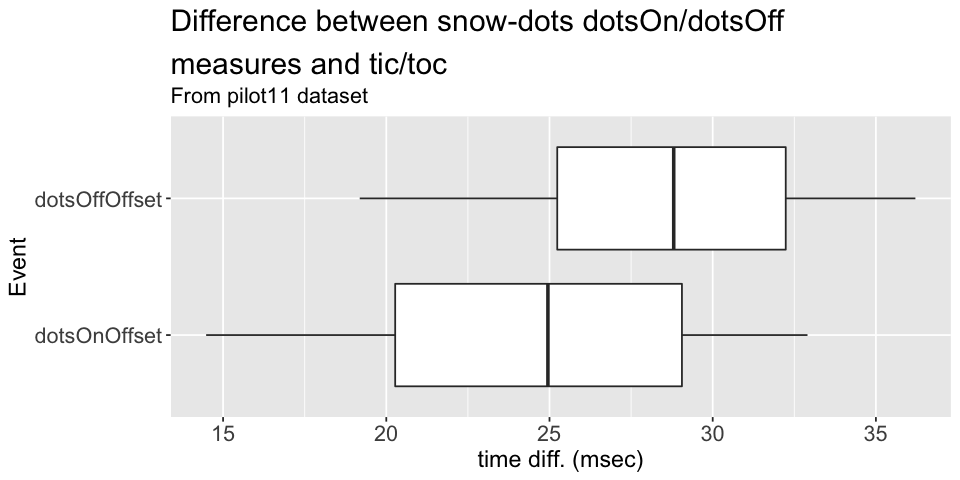

In [34]:
ticTocOffsets <- wideTimestamps[,.(validTrialCount, 
                                   dotsOnOffset=nDotsOn-nTocDotsOn, 
                                   dotsOffOffset=nDotsOff-nTocDotsOff)]

# control output figure size
options(repr.plot.width=8, repr.plot.height=4)
ggplot(melt(ticTocOffsets,
            id.vars=c("validTrialCount"),
            measure.vars=c("dotsOnOffset","dotsOffOffset"),
            value.name="timestamp", variable.name="Event"), 
       aes(Event, 1000*timestamp)) + 
    geom_boxplot(outlier.colour = "red", outlier.shape = 1) + #good ref https://ggplot2.tidyverse.org/reference/geom_boxplot.html
    coord_flip() +
    labs(title="Difference between snow-dots dotsOn/dotsOff\nmeasures and tic/toc",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="time diff. (msec)") +
    theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
            plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text


## Checking that the three datasets are consistent

### Timing of trial vs. timing of frames

#### Frame timings
what time gaps do I observe between `dotsOn` and 1st frame `onsetTime`, and last frame `onsetTime` and `dotsOff`?

In [35]:
# get times of first and last frame in each trial, align everything to dotsOn
# extremeFrameTimes <- frameTimes[,.(firstFrame=min(onsetTime-trialStart)-dotsOn, 
#                                    lastFrame=max(onsetTime-trialStart)-dotsOn,
#                                    trialStart, 
#                                    dotsOn=dotsOn-dotsOn, 
#                                    dotsOff=dotsOff-dotsOn),
#                                   by=validTrialCount]
print("skipped for now")
# str(extremeFrameTimes)

[1] "skipped for now"


In [36]:
# visualization in this cell not very interesting/readable
# probably better to switch to the boxplots as above
# transform to long format for ggplot 
# longTimeData <- melt(extremeFrameTimes, 
#                     id.vars=c("validTrialCount"),
#                     measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
#                     variable.name="Event", value.name="timestamp")
# #str(longTimeData)


# frameDurations <- c(6*FRAME_DURATION, 140*FRAME_DURATION)

# # control output figure size
# options(repr.plot.width=8, repr.plot.height=8)

# # plot
# ggplot(longTimeData, aes(x=validTrialCount, y=timestamp)) + 
#     geom_point(aes(col=Event), size=POINT_SIZE) +
# #    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = FRAME_DURATION, linetype="dashed") +
#    annotate("text", x=16, y=FRAME_DURATION, vjust = -1, label = c("1 frame")) +
#    guides(colour = guide_legend(reverse=T)) +
#    labs(title="Stimulus Timestamps",
#          subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
#          y="Aligned Time (sec)") + 
#     theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
#             plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
#             plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # caption
#             axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
#             axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
#             axis.text.x=element_text(size=AXES_FONT),  # X axis text
#             axis.text.y=element_text(size=AXES_FONT))  # Y axis text

#### Tight/skipped frames 
<a id='tightFrames'></a>
Exploration of `Tight` frames in each trial

In [37]:
# plot
# recall that frameTimes is defined in section #frame_times
# only produce plot if non-tight frames exist:
if (nrow(frameTimes[isTight == 0])>0) {
    cat('total of skipped frames = ',frameTimes[,sum(!isTight)])
    ggplot(frameTimes, aes(x=validTrialCount, y=onsetTime-(dotsOn+trialStart))) + 
       geom_point(aes(col=factor(isTight)), size=2) +
       labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="onsetTime aligned to dotsOn (sec)",
        color="Tight") + 
       theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text
} else {
    print("all frames are tight in the valid trials")
}


[1] "all frames are tight in the valid trials"


# Accuracy analysis
<a id='acc'></a>
- Accuracy (% correct) on all trials with non-zero coherence

In [ ]:
accuracy <- TRIALS[coherence > 0 & !is.na(validTrialCount),sum(correct)/.N]
cat('accuracy on trials with non-zero coherence:', accuracy * 100,"%", sep = '')

## Psychophysical curves
Recall that rightward motion corresponds to direction 0 degrees and choice 1.
Below, we set the coherence to its negative counterpart every time 
the direction of motion at the end of the trial is leftward (180 degrees).

In [ ]:
# create a specific column signedCoherence
TRIALS[, signedCoherence := coherence]
TRIALS[endDirection==180, signedCoherence := -coherence]

z <- 1.96 # For 95% confidence intervals
# create new data.table with columns "propChooseRight" and "se" (for standard error)
ppTable1 <- TRIALS[, .(propChooseRight=sum(choice)/.N, n=.N), by=signedCoherence]
ppTable1[,se:=sqrt(propChooseRight*(1-propChooseRight)/n)]
ppTable1[,ci:=z*se]

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)
ggplot(ppTable1, aes(x=signedCoherence, y=propChooseRight)) +
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), width=ERROR_WIDTH) +
    geom_line() +
    geom_point() +
    ggtitle("Psychophysical curve\nwith 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Psychophysical curves grouped by change-point condition
Let's compute the same curve, separating CP and non-CP trials

In [ ]:
ppTableCP <- TRIALS[presenceCP==1, .(propChooseRightCP=sum(choice)/.N, nCP=.N), by=signedCoherence]
ppTableCP[,seCP:=sqrt(propChooseRightCP*(1-propChooseRightCP)/nCP)]
ppTableNonCP <- TRIALS[presenceCP==0, .(propChooseRightNonCP=sum(choice)/.N, nNonCP=.N), by=signedCoherence]
ppTableNonCP[,seNonCP:=sqrt(propChooseRightNonCP*(1-propChooseRightNonCP)/nNonCP)]

In [ ]:
# merge the two tables and put them in long format
setkey(ppTableCP, signedCoherence)
setkey(ppTableNonCP, signedCoherence)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
psychophys <- merge(ppTableCP,ppTableNonCP,all=TRUE)

# convert to long format
longPsychophys <- melt(psychophys, 
                    id.vars=c("signedCoherence","seCP","seNonCP"),
                    measure.vars=c("propChooseRightCP","propChooseRightNonCP"),
                    variable.name="CPcategory", value.name="propChooseRight")

# add se col
longPsychophys[,se:=seCP]
longPsychophys[CPcategory=='propChooseRightNonCP', se:=seNonCP]
longPsychophys[,ci:=z*se]

# head(psychophys)
# head(longPsychophys)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# ref on error bars
# http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_(ggplot2)/

pd <- position_dodge(1.5)
# ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight)) +
#     geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci, col=CPcategory), width=.1, position=pd) +
#     geom_line(aes(col=CPcategory),position=pd) +
#     geom_point(aes(col=CPcategory),position=pd)

ggplot(longPsychophys, aes(x=signedCoherence, y=propChooseRight, colour=CPcategory, group=CPcategory)) + 
    geom_errorbar(aes(ymin=propChooseRight-ci, ymax=propChooseRight+ci), colour="black", width=ERROR_WIDTH, position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("% coherence (+- for direction)") +
    ylab("Proportion Choose Right") +
    scale_colour_hue(name="Trial type",    # Legend label, use darker colors
                     breaks=c("propChooseRightCP", "propChooseRightNonCP"),
                     labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Psychophysics curves grouped by CP presence\nwith 95% confidence intervals") +
    expand_limits(y=0) +                        # Expand y range
    scale_y_continuous(breaks=c(0,.25,0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right

## Accuracy as a function of viewing duration

In [ ]:
# first get marginal frequencies
toDisplay <- TRIALS[coherence > 0,.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay[,accuracy := correct/freq]
toDisplay[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# head(toDisplay)

pd <- position_dodge(0)
ggplot(toDisplay, aes(x=viewingDuration, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=0.03, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd) +
    ggtitle("Percent correct on non-zero coherence trials\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Grouped by change-point condition
And now separating according to change point trials:

In [ ]:
# first get marginal frequencies
accDuration <- TRIALS[coherence > 0,.(freq = .N, correct = sum(correct)), by=.(viewingDuration,presenceCP)]


# then add the accuracy column
accDuration[,accuracy := correct/freq]

# head(accDuration)

# # conver to long format
# longAccDuration <- melt(accDuration, 
#                     id.vars=c("viewingDuration"),
#                     measure.vars=c("accuracy"),
#                     variable.name="CPcategory", value.name="accuracy")

# head(longAccDuration)

# add standard error column
accDuration[,se := sqrt(accuracy * (1-accuracy)/ freq)]

# set presenceCP to factor variable
accDuration[,presenceCP := as.factor(presenceCP)]

# head(toDisplay)

# control output figure size
options(repr.plot.width=8, repr.plot.height=7)

pd <- position_dodge(.01)

ggplot(accDuration, aes(x=viewingDuration, y=accuracy, colour=presenceCP, group=presenceCP)) + 
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=SMALL_ERROR_WIDTH, colour="black", position=pd) +
    geom_line(position=pd, size=LINE_WIDTH) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("viewing duration (sec)") +
    ylab("Percent Correct") +
    scale_colour_hue(name="CP presence",    # Legend label, use darker colors
#                      breaks=c("propChooseRightCP", "propChooseRightNonCP"),
#                      labels=c("CP", "No CP"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("Accuracy as function of viewing duration\nwith 95% confidence intervals (and 0%-coh excluded)") +
    expand_limits(y=c(0.5,1)) +                        # Expand y range
    scale_y_continuous(breaks=c(0.5,0.75,1)) +         # Set tick every 4
    theme_bw() +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
          plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
          plot.caption=element_text(size=15),  # caption
          axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
          axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
          axis.text.x=element_text(size=AXES_FONT),  # X axis text
          axis.text.y=element_text(size=AXES_FONT),  # Y axis text
          legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right
  

## Accuracy as a function of coherence level

In [ ]:
# first get marginal frequencies
accCoh <- TRIALS[,.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
accCoh[,accuracy := correct/freq]
accCoh[,se := sqrt(accuracy * (1-accuracy)/ freq)]
# deal with coh=0 artificially
accCoh[coherence==0, accuracy:=0.5]
accCoh[coherence==0, se:=0]

# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

# pd <- position_dodge(0)
ggplot(accCoh, aes(x=coherence, y=accuracy)) +
    geom_errorbar(aes(ymin=accuracy-z*se, ymax=accuracy+z*se), width=ERROR_WIDTH) +
    geom_line(size=.8*LINE_WIDTH) +
    geom_point(size=1.6*POINT_SIZE, fill="white", shape=21) +
    ggtitle("Percent correct as a 11:00amfunction of coherence\n 95% confidence intervals") +
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Autocorrelation of choices
<a id='autocorr'></a>

In [ ]:
# control output figure size
options(repr.plot.width=6, repr.plot.height=4)

acf(TRIALS[!is.na(choice), choice, by=trialCount]$choice)

And of trials' `endDirection`.

In [ ]:
acf(TRIALS[!is.na(choice), endDirection, by=trialCount]$endDirection)

# Dot count in hemifields for 0-coherence trials
<a id='dotcount'></a>

I wonder whether the difference between the number of dots in the right and left halves of the stimulus aperture predicts subject's responses on 0-coherence trials.

In [ ]:
str(DOTS)

In [ ]:
zeroCohTrials <- TRIALS[!is.na(trialCount) & coherence == 0, .(choice, viewingDuration), by=trialCount]
setkey(zeroCohTrials, trialCount)
setkey(DOTS, trialCount)

# inner join syntax
zeroCohDots <- zeroCohTrials[DOTS, nomatch=0]
# nrow(zeroCohTrials)
# nrow(zeroCohDots[,.N,by=trialCount])

# add boolean columns to flag hemifield location of dots
zeroCohDots[,`:=`(rightDots = xpos>=0.5 & isActive, leftDots = xpos < 0.5 & isActive)]
diffDots <- zeroCohDots[,diffDots:=sum(rightDots)-sum(leftDots), by=trialCount]


# control output figure size
options(repr.plot.width=8, repr.plot.height=5)

ggplot(diffDots, aes(x=trialCount, y=diffDots)) +
    geom_point(aes(shape=factor(choice))) + 
    facet_wrap( ~ viewingDuration) + 
    guides(shape = guide_legend(reverse=T)) +
    labs(shape="choice")

In [ ]:
# control output figure size
options(repr.plot.width=5, repr.plot.height=3)

print("Should I use lm or a Spearman rank correlation test instead?")
#refs on Spearman rank correlation test
# http://www.biostathandbook.com/spearman.html
# http://rcompanion.org/rcompanion/e_02.html
# summary(lm(diffDots ~ factor(choice), diffDots))

ggplot(diffDots, aes(x=as.factor(choice), y=diffDots)) +
    geom_point() 

# Reverse Correlation Analysis
<a id='revker'></a>

## Number of coherent dots per frame

Let's display the number of coherent dots on each frames, grouping by subject's choice.

In [96]:
# count coherent dots on each frame
cohDots <- unique(DOTS[!is.na(validTrialCount),
                       .(numCohDots=sum(isCoherent), 
                       initDirection, 
                       endDirection, 
                       presenceCP, 
                       correct,
                       coherence,
                       viewingDuration,
                       choice),
                       by=.(frameIdx, validTrialCount)]) # I should not have to call unique() here... :(

# see if some frames have 0 coherent dots
# unique(cohDots[numCohDots == 0,.(validTrialCount)])

In [98]:
# let's try to sign numCohDots according to the direction of motion (+ for R and - for L)
## add a copy of numCohDots column named signedNumCohDots, and an ID col that just indexes the rows
cohDots[,"signedNumCohDots" := .(numCohDots)]

In [99]:
## on non-cp trials, adjust sign according to initDirection
cohDots[initDirection == "180" & !presenceCP, signedNumCohDots := -numCohDots] 

In [100]:
## on cp-trials,
    # rough estimate of number of frames that are before the CP (for now)
if (length(unique(TRIALS$timeCP)) == 1) {
    foreFrameCount <- TRIALS[,timeCP][1] * FRAME_RATE_ESTIMATE
} 

In [101]:
foreFrameCount

[1] 12

In [102]:
rows <- cohDots[, .(rowNumber=.I[initDirection=="180" & presenceCP]), by=.(validTrialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx <= foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx <= foreFrameCount,rowNumber]]

In [103]:
rows <- cohDots[, .(rowNumber=.I[initDirection=="0" & presenceCP]), by=.(validTrialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx > foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx > foreFrameCount,rowNumber]]

In [82]:
# diagnostic
# unique(cohDots[presenceCP == TRUE,
#                .(initDirection,endDirection,presenceCP,numCohDots,signedNumCohDots) ,
#                by=.(frameIdx,validTrialCount)])

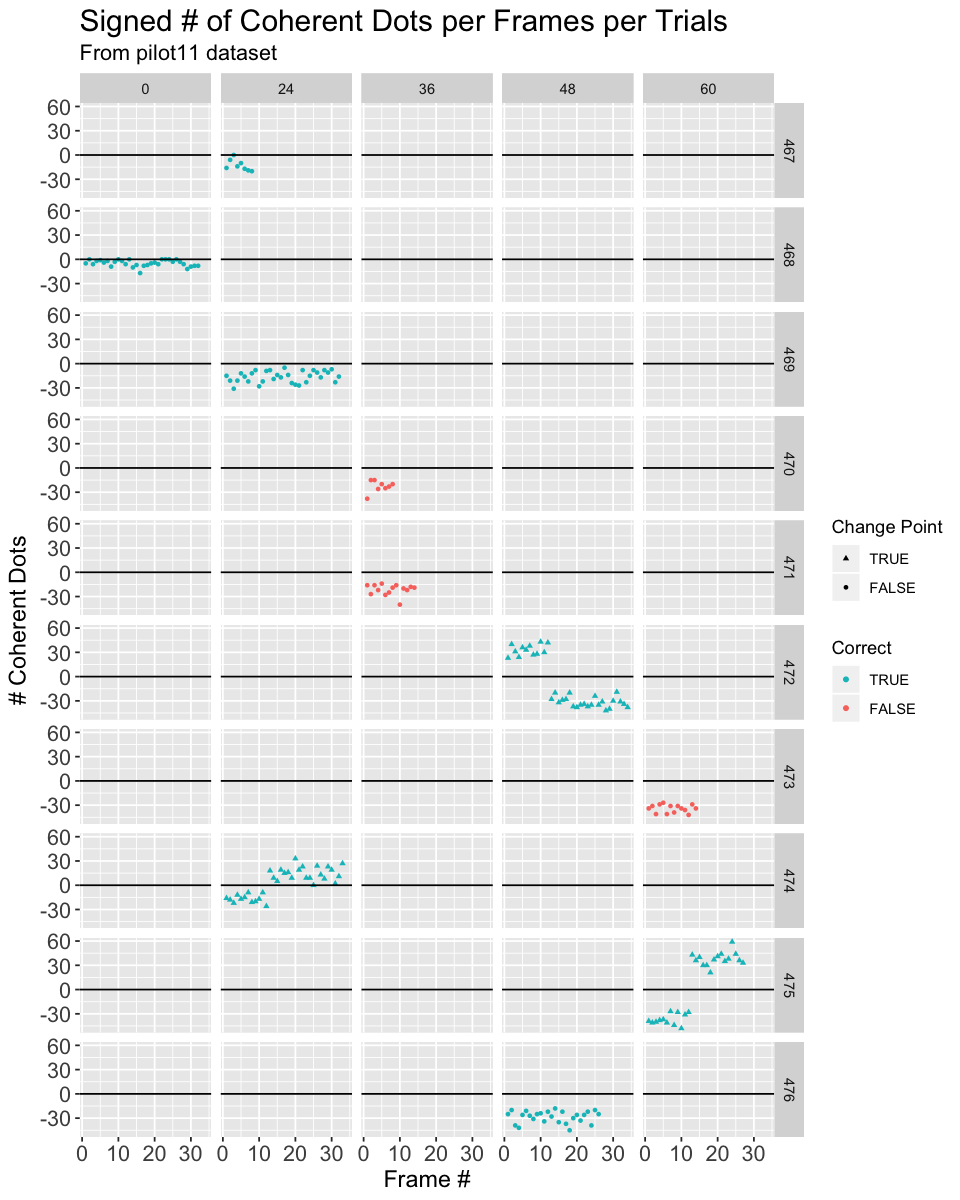

In [104]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=10)


# plot
ggplot(cohDots[validTrialCount > 466], aes(x=frameIdx, y=signedNumCohDots)) + 
    geom_point(aes(col=correct, shape=presenceCP), size=SMALL_DOT_SIZE) +
    facet_grid(validTrialCount~coherence) +
#    geom_line(aes(col=Event),size=.2) +
    geom_hline(yintercept = 0) +
    guides(colour = guide_legend(reverse=T), shape = guide_legend(reverse=T)) +
    labs(title="Signed # of Coherent Dots per Frames per Trials",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="# Coherent Dots",
         x="Frame #",
         color="Correct", shape="Change Point") + 
    theme(plot.title=element_text(size=PLOT_TITLE_FONT_SIZE, lineheight=1.2),  # title
            plot.subtitle=element_text(size=PLOT_SUBTITLE_FONT_SIZE),  # subtitle
            plot.caption=element_text(size=PLOT_SUBTITLE_FONT_SIZE),                                 # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

### Attempt at reverse kernels

What I will attempt here is the following:  
*display the average across trials, frame-by-frame, of the ME measure, conditioned on the subject's choice, and grouped by CP presence and viewing duration.*

In [111]:
revKerNumCohDots <- cohDots[, .(ME=mean(signedNumCohDots), 
                                numTrials=.N,
                                sem=sd(signedNumCohDots) / sqrt(.N)), 
                            by=.(viewingDuration, presenceCP, frameIdx, choice)]

In [112]:
head(revKerNumCohDots)

viewingDuration,presenceCP,frameIdx,choice,ME,numTrials,sem
0.5,FALSE,1,0,-11.653846,26,4.210954
0.5,FALSE,2,0,-8.346154,26,4.866824
0.5,FALSE,3,0,-12.000000,26,4.690744
0.5,FALSE,4,0,-11.576923,26,4.554009
0.5,FALSE,5,0,-11.153846,26,4.117390
0.5,FALSE,6,0,-13.192308,26,4.320263


In [113]:
revKerNumCohDots[,.(min(numTrials),max(numTrials))]

V1,V2
1,65


In [114]:
str(cohDots)

Classes ‘data.table’ and 'data.frame':	9357 obs. of  11 variables:
 $ frameIdx        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ validTrialCount : int  1 1 1 1 1 1 1 1 1 1 ...
 $ numCohDots      : int  43 40 40 43 43 42 41 42 25 35 ...
 $ initDirection   : Factor w/ 2 levels "0","180": 2 2 2 2 2 2 2 2 2 2 ...
 $ endDirection    : Factor w/ 2 levels "0","180": 2 2 2 2 2 2 2 2 2 2 ...
 $ presenceCP      : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ correct         : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ coherence       : int  60 60 60 60 60 60 60 60 60 60 ...
 $ viewingDuration : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ choice          : Factor w/ 3 levels "0","1","NaN": 1 1 1 1 1 1 1 1 1 1 ...
 $ signedNumCohDots: int  -43 -40 -40 -43 -43 -42 -41 -42 -25 -35 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [116]:
unique(revKerNumCohDots[numTrials < 5])[order(viewingDuration)]

viewingDuration,presenceCP,frameIdx,choice,ME,numTrials,sem
0.1,FALSE,9,1,-12.666667,3,10.477489
0.2,FALSE,15,1,6.333333,3,14.621141
0.2,FALSE,15,0,5.000000,1,NA
0.3,TRUE,22,1,3.000000,3,6.506407
0.3,TRUE,22,0,-18.333333,3,9.386752
0.3,FALSE,21,0,-28.000000,1,NA
0.4,FALSE,27,1,1.000000,3,7.000000
0.4,FALSE,27,0,-27.000000,3,16.165808
0.4,TRUE,28,0,-28.750000,4,3.326034
0.5,TRUE,34,0,-5.750000,4,14.721724


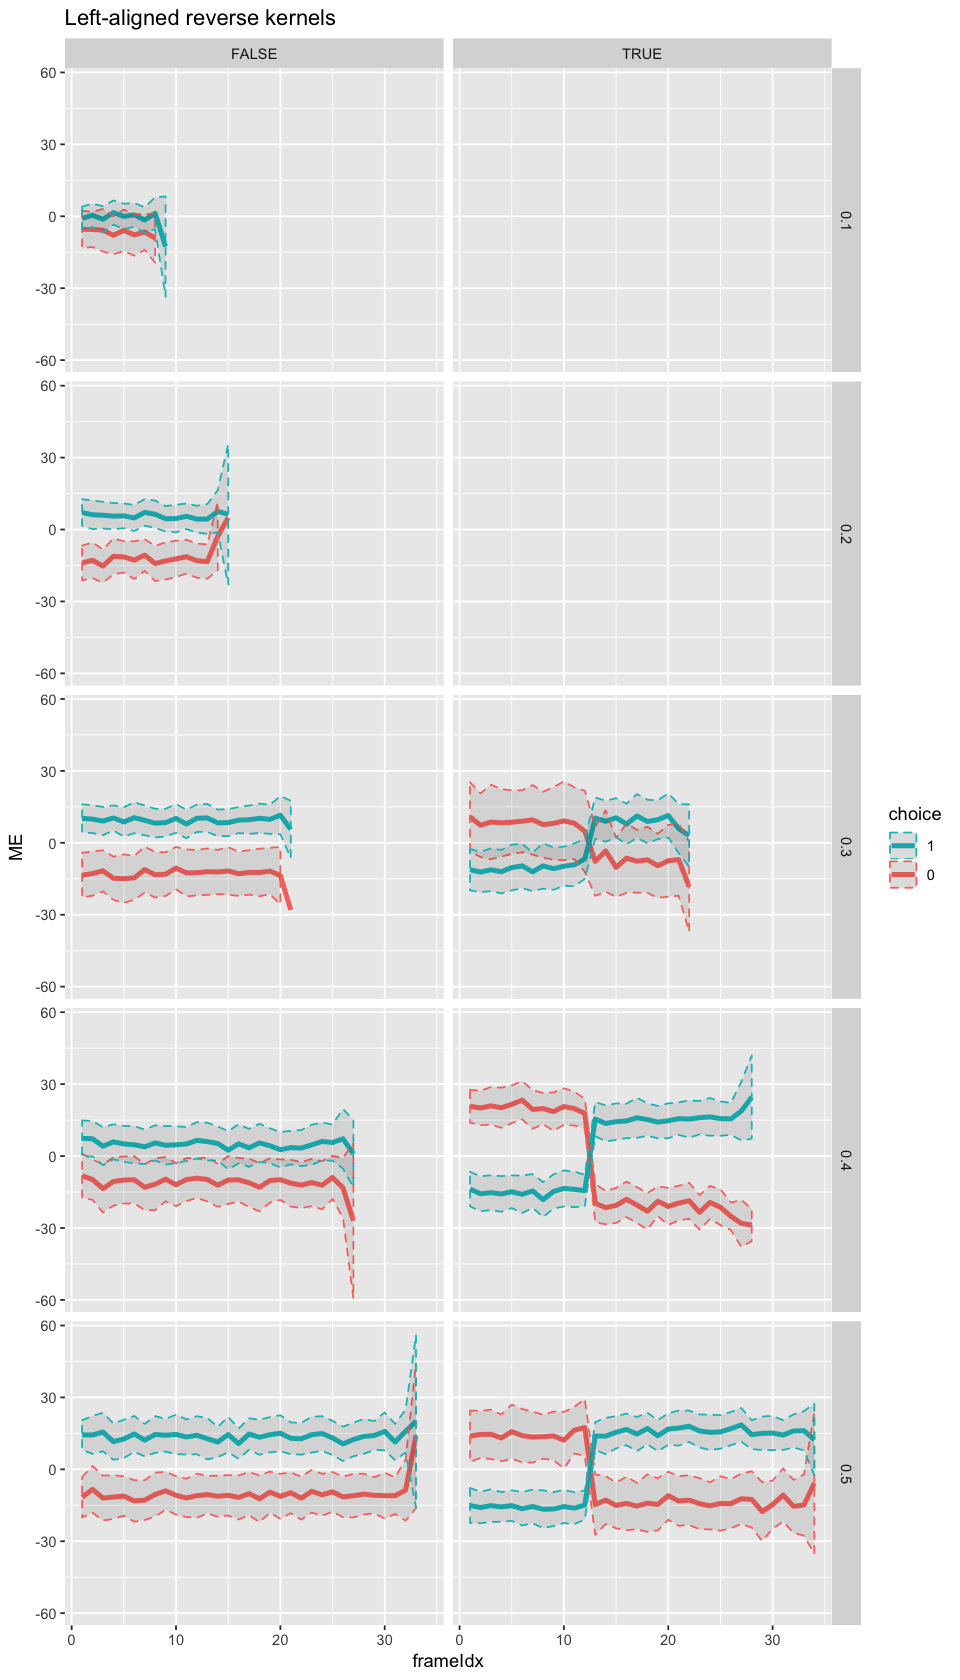

In [130]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=14)

ggplot(revKerNumCohDots,aes(x=frameIdx,y=ME), colour=choice, group=choice) +
    geom_line(aes(col=choice), size=LINE_WIDTH) + 
    geom_ribbon(aes(ymin=ME-2*sem, ymax=ME+2*sem, col=choice), linetype=2, alpha=0.1) +
#     geom_errorbar(aes(ymin=ME-2*sem, ymax=ME+2*sem), colour="black", width=SMALL_ERROR_WIDTH)+
    facet_grid(viewingDuration~presenceCP) +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Left-aligned reverse kernels")

In [128]:
print("Unfortunately, some CP trials have one more frame than non-CP trials:")
cohDots[order(viewingDuration, presenceCP),.(maxNumFrame=max(frameIdx)),by=.(viewingDuration, presenceCP)][viewingDuration>.2]

[1] "Unfortunately, some CP trials have one more frame than non-CP trials:"


viewingDuration,presenceCP,maxNumFrame
0.3,FALSE,21
0.3,TRUE,22
0.4,FALSE,27
0.4,TRUE,28
0.5,FALSE,33
0.5,TRUE,34


Not sure what I should do with these kernels. Should I trim one of their ends? Should I try to right-align them somehow?

# Miscellaneous
##  Explore random seed

In [ ]:
seedTable <- TRIALS[,.(randSeedBase,trialIndex),by=trialCount]

# control output figure size
options(repr.plot.width=7, repr.plot.height=6)

g <- ggplot(seedTable, aes(x=trialCount, y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text